In [1]:
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras # Using TensorFlow backend.
import tensorflow as tf
import random
from keras.layers import  Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from PIL import Image, ImageOps
from skimage import io, color
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler 

In [2]:
# Read data with labels
data_labels = pd.read_csv(r"C:\Users\giant\hasyv2-dataset-friend-of-mnist\HASYv2\hasy-data-labels.csv")

In [3]:
# Display top 5 records to show the data was imported successfully
data_labels.tail()

,path,symbol_id,latex,user_id
168367,hasy-data/v2-190036.png,1555,\smile,1
168368,hasy-data/v2-190037.png,1555,\smile,1
168369,hasy-data/v2-190038.png,1555,\smile,1
168370,hasy-data/v2-190039.png,1555,\smile,1
168371,hasy-data/v2-190040.png,1555,\smile,1


In [4]:
# Dsiplay sample of all unique labels supported for symbols
unique = list(data_labels["latex"].unique())
print(random.sample(unique,15))

['\\varpropto', 'Z', 'u', '\\mathds{R}', '\\trianglelefteq', '\\star', 'n', '\\mathcal{G}', '\\backslash', '\\xi', 'N', '\\neq', '\\circledR', '\\mathcal{E}', '\\dotsc']


In [90]:
# Extracting data only for labels we are interested in
df = data_labels.loc[data_labels["latex"].isin(['0','1','2','3','4','5','6','7','8','9','\\pi','\\frown','\\smile',
                                                '+','-','/','|',']','[','=','\\ast','\\bullet',
                                                '\\leq', '\\geq', '<', '>','\\div','\\times',
                                                'A', 'B', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M',
                                                'N', 'Q', 'R', 'T', 'U', 'V', 'Y', 'Z','\\cdot',
                                                'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'm',
                                                'n', 'p', 'q', 'r', 's','u', 'v', 'w', 'x', 'y', 'z'])]

<AxesSubplot:>

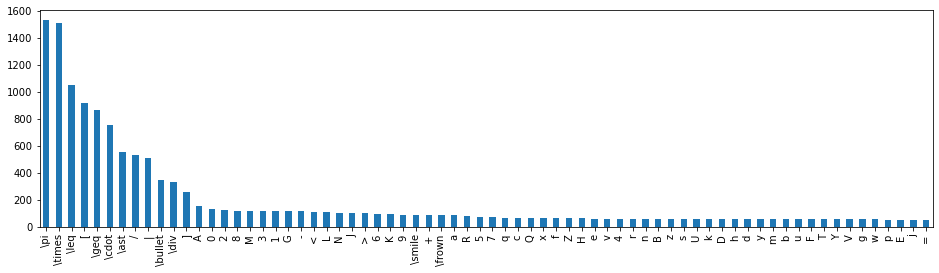

In [91]:
# Plot number of images per labels
df = df[['path','latex']]
df = df.sample(frac=1)
df.shape
df.latex.value_counts().plot.bar(figsize=(16, 4))

In [92]:
# To fight class imbalance, we prepare data for undersampling by creating dict
# of classes with high counts
s = df.latex.value_counts()
s = s.to_dict()
s['\\pi']=335;s['\\times']=335;s['\\leq']=335;s['\\geq']=335;
s['\\cdot']=335;s['\\ast']=335;s['\\bullet']=335;s['\\div']=335;
s['/']=335;s['|']=335;s['[']=335

<AxesSubplot:>

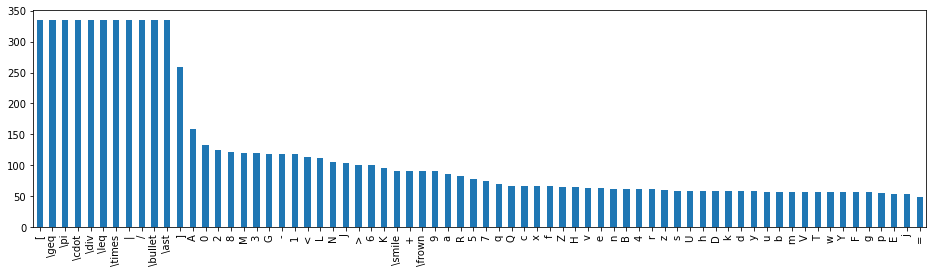

In [93]:
# Perform undersampling, then plot results
Xn, yn = RandomUnderSampler(sampling_strategy=s).fit_resample(X=df['path'].values.reshape(-1, 1), y=df['latex'])
df2 = pd.DataFrame(data=Xn,columns=['path'])
df2['latex']=yn
df2 = df2.sample(frac=1)
df2.latex.value_counts().plot.bar(figsize=(16, 4))

<AxesSubplot:>

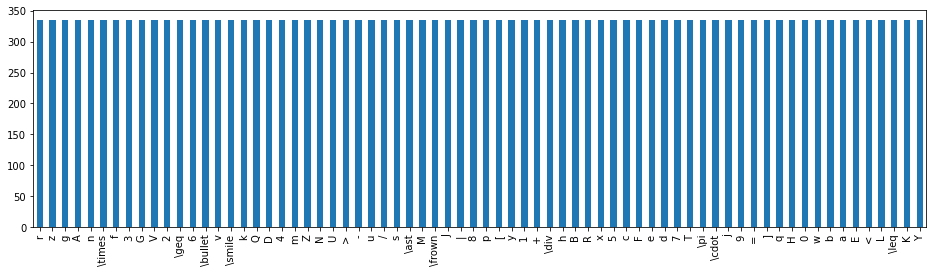

In [94]:
# Perform oversampling to make each class contain same number of images
Xn, yn = RandomOverSampler().fit_resample(X=df2['path'].values.reshape(-1, 1), y=df2['latex'])
df2 = pd.DataFrame(data=Xn,columns=['path'])
df2['latex']=yn
df2 = df2.sample(frac=1)
df2.latex.value_counts().plot.bar(figsize=(16, 4))

In [95]:
# Preparing training data as numpy array of vectors from raw images
base = 'C:\\Users\\giant\\hasyv2-dataset-friend-of-mnist\\HASYv2\\'

listOfB = []
bad = []
for items in df2['path'].iteritems(): 
    pil_im = Image.open(base +items[1], 'r')
    pil_im = ImageOps.grayscale(pil_im)
    pil_im = pil_im.convert('RGB')
    array1 = np.asarray(pil_im)/255.
    listOfB.append(array1)
B = np.array(listOfB) 
train_x = B
train_x.shape

(23450, 32, 32, 3)

In [96]:
# Get number of classes
classes = ['0','1','2','3','4','5','6','7','8','9','\\pi','\\frown','\\smile',
            '+','-','/','|',']','[','=','\\ast','\\bullet',
            '\\leq', '\\geq', '<', '>','\\div','\\times',
            'A', 'B', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M',
            'N', 'Q', 'R', 'T', 'U', 'V', 'Y', 'Z','\\cdot',
            'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'm',
            'n', 'p', 'q', 'r', 's','u', 'v', 'w', 'x', 'y', 'z']
len(classes)

70

In [97]:
# Preparing categorical labels for multiclass classification (categorical crossentropy)
train_y = df2['latex']
listOfk = []
for items in df2['latex'].iteritems():
    intermediate = np.zeros(len(classes))
    index = classes.index(items[1])
    intermediate[index] = 1
    listOfk.append(intermediate)
categorical_labels = np.array(listOfk) 
train_y = categorical_labels
print(train_y.shape)

(23450, 70)


In [98]:
# # preparing neural network model using keras API
model = keras.models.Sequential()
model.add(Conv2D(32,kernel_size=(5, 5),strides=(2, 2),padding="same",input_shape=(32,32,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
model.add(Conv2D(32,kernel_size=(5, 5),activation='relu',padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32,kernel_size=(5, 5),activation='relu',padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(32))
model.add(Dense(70, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 16, 16, 32)        2432      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 8, 8, 32)          25632     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 4, 4, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 4, 4, 32)          25632     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 2, 2, 32)        

In [99]:
# Create Data Augmentation Generator
data_generator_with_aug = keras.preprocessing.image.ImageDataGenerator(validation_split=.2, width_shift_range=.12,
                                                                       height_shift_range=.12, rotation_range=18,
                                                                       zoom_range=.12, shear_range=.12, rescale=0.05)

# separate data into training and validation sets
training_data_generator = data_generator_with_aug.flow(train_x, train_y, subset='training')
validation_data_generator = data_generator_with_aug.flow(train_x, train_y, subset='validation')

# Fit the Model
history = model.fit(training_data_generator, #class_weight=weights,
                    epochs=10,validation_data=validation_data_generator)

Epoch 1/10
587/587 [==============================] - 26s 43ms/step - loss: 3.1464 - accuracy: 0.1937 - val_loss: 1.9903 - val_accuracy: 0.4107
Epoch 2/10
587/587 [==============================] - 29s 49ms/step - loss: 1.5634 - accuracy: 0.5398 - val_loss: 1.2620 - val_accuracy: 0.6166
Epoch 3/10
587/587 [==============================] - 25s 43ms/step - loss: 1.1340 - accuracy: 0.6541 - val_loss: 1.0268 - val_accuracy: 0.6932
Epoch 4/10
587/587 [==============================] - 24s 41ms/step - loss: 0.9449 - accuracy: 0.7064 - val_loss: 0.8865 - val_accuracy: 0.7292
Epoch 5/10
587/587 [==============================] - 23s 39ms/step - loss: 0.8439 - accuracy: 0.7339 - val_loss: 0.7554 - val_accuracy: 0.7601
Epoch 6/10
587/587 [==============================] - 24s 42ms/step - loss: 0.7693 - accuracy: 0.7537 - val_loss: 0.7277 - val_accuracy: 0.7608
Epoch 7/10
587/587 [==============================] - 24s 41ms/step - loss: 0.7090 - accuracy: 0.7690 - val_loss: 0.6829 - val_accuracy:

In [100]:
# Save model for accessing later
model.save(r'C:\Users\giant\hasyv2-dataset-friend-of-mnist\HASYv2\maths_model.h5')